In [ ]:
pip install python-dotenv pandas matplotlib seaborn

In [414]:
import pandas as pd
import requests
import time
from dotenv import load_dotenv
import os
import json
import yaml
import ast
import matplotlib.pyplot as plt
import seaborn as sns


load_dotenv() 

True

In [2]:
# Configuration
GIT_REPO_FILTERED = "files/git_repo_filtered_js_commit_date.csv"
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")
GRAPHQL_URL = "https://api.github.com/graphql"
HEADERS = {
    "Authorization": f"Bearer {GITHUB_TOKEN}",
    "Accept": "application/vnd.github+json"
}

repos_from_csv = []

repos_with_CI = set()
invalid_repos = set()
repos_with_no_workflows = set()
repos_with_network_error = set()
repo_name_to_branch = {}

In [28]:

def read_filtered_repo_csvlist():
    df = pd.read_csv(GIT_REPO_FILTERED)

    # Split 'name' into owner and repo
    for _, row in df.iterrows():
        if '/' not in row['name']:
            print(f"Skipping invalid repo name: {row['name']}")
            continue
        owner, repo_name = row['name'].split('/', 1)
        repos_from_csv.append({
            "owner": owner.strip(),
            "name": repo_name.strip(),
            "default_branch": row['default_branch'].strip()
        })
        repo_name_to_branch[f"{owner.strip()}/{repo_name.strip()}".lower()] = row['default_branch'].strip()

    print(repos_from_csv[:5])

read_filtered_repo_csvlist()

[{'owner': 'bigbluebutton', 'name': 'bigbluebutton', 'default_branch': 'v3.0.x-release'}, {'owner': 'zabinx', 'name': 'duskrpg', 'default_branch': 'master'}, {'owner': 'apache', 'name': 'cordova-android', 'default_branch': 'master'}, {'owner': 'aws-samples', 'name': 'aws-dynamodb-examples', 'default_branch': 'master'}, {'owner': 'dgarijo', 'name': 'widoco', 'default_branch': 'master'}]


In [29]:
# Step 2: Build GraphQL query for multiple repos
def build_query_to_check_workflows(repos, start, end):
    query_parts = []
    for i, repo in enumerate(repos[start:end]):
        query_parts.append(f"""
        repo{i}: repository(owner: "{repo['owner']}", name: "{repo['name']}") {{
            workflows: object(expression: "{repo['default_branch']}:.github/workflows") {{
                ... on Tree {{
                    entries {{
                        name
                        type
                    }}
                }}
            }}
        }}
        """)
    full_query = "query { " + " ".join(query_parts) + " }"
    # print("query:", full_query)
    return full_query

In [18]:
# Step 3: Execute query and parse results
def check_workflows(repos, start, end):
    try:
        query = build_query_to_check_workflows(repos, start, end)
        response = requests.post(GRAPHQL_URL, json={"query": query}, headers=HEADERS)
        response.raise_for_status()
        data = response.json()

        # If GitHub responds with an error (403, 502, etc.)
        if response.status_code != 200:
            print(f"Skipping batch {start}:{end} (HTTP {response.status_code})")
            for repo in repos[start:end]:
                repos_with_network_error.add(f"{repo['owner']}/{repo['name']}")
            return

        data = response.json()

        for i, repo in enumerate(repos[start:end]):
            key = f"repo{i}"
            repo_data = data.get("data", {}).get(key, {})

            if not repo_data:
                invalid_repos.add(f"{repo['owner']}/{repo['name']}")
                continue
            workflows = repo_data.get("workflows")

            if workflows and workflows.get("entries"):
                repos_with_CI.add(f"{repo['owner']}/{repo['name']}")
            else:
                repos_with_no_workflows.add(f"{repo['owner']}/{repo['name']}")
    except requests.exceptions.RequestException as e:
        print(f"Request failed for batch {start}:{end}: {e}")
        for repo in repos[start:end]:
            repos_with_network_error.add(f"{repo['owner']}/{repo['name']}")

In [20]:
start = 0
batch_size = 100
limit = len(repos_from_csv)

repos_with_CI = set()
invalid_repos = set()
repos_with_no_workflows = set()
repos_with_network_error = set()

for start in range(start, limit, batch_size):
    end = min(start + batch_size, limit)
    check_workflows(repos_from_csv, start, end)
    print(f"Processed {start} to {end}. repos_with_CI:{len(repos_with_CI)} repos_with_network_error:{len(repos_with_network_error)} repos_with_no_workflows:{len(repos_with_no_workflows)} invalid_repos:{len(invalid_repos)}")
    time.sleep(5)

Processed 0 to 100. repos_with_CI:54 repos_with_network_error:0 repos_with_no_workflows:45 invalid_repos:1
Processed 100 to 200. repos_with_CI:120 repos_with_network_error:0 repos_with_no_workflows:77 invalid_repos:3
Processed 200 to 300. repos_with_CI:152 repos_with_network_error:0 repos_with_no_workflows:144 invalid_repos:4
Processed 300 to 400. repos_with_CI:177 repos_with_network_error:0 repos_with_no_workflows:219 invalid_repos:4
Processed 400 to 500. repos_with_CI:194 repos_with_network_error:0 repos_with_no_workflows:301 invalid_repos:5
Processed 500 to 600. repos_with_CI:228 repos_with_network_error:0 repos_with_no_workflows:366 invalid_repos:6
Processed 600 to 700. repos_with_CI:259 repos_with_network_error:0 repos_with_no_workflows:435 invalid_repos:6
Processed 700 to 800. repos_with_CI:283 repos_with_network_error:0 repos_with_no_workflows:511 invalid_repos:6
Processed 800 to 900. repos_with_CI:310 repos_with_network_error:0 repos_with_no_workflows:583 invalid_repos:7
Proces

In [21]:
# Save each set to a separate file
def save_repo_names_to_file():
    with open("files/repos_with_CI.txt", "w") as f:
        for repo in (repos_with_CI):
            f.write(repo + "\n")

    with open("files/repos_with_no_workflows.txt", "w") as f:
        for repo in (repos_with_no_workflows):
            f.write(repo + "\n")

    with open("files/invalid_repos.txt", "w") as f:
        for repo in (invalid_repos):
            f.write(repo + "\n")

    with open("files/repos_with_network_error.txt", "w") as f:
        for repo in (repos_with_network_error):
            f.write(repo + "\n")

In [22]:
save_repo_names_to_file()

In [47]:
# retrying repos with network error
unchecked_repos = []
for error_repo in repos_with_network_error:
    owner, repo_name = error_repo.split('/', 1)
    unchecked_repos.append({
        "owner": owner.strip(),
        "name": repo_name.strip(),
        "default_branch": repo_name_to_branch[f"{owner.strip()}/{repo_name.strip()}"].strip()
    })

batch_size = 100
repos_with_network_error = set()

for start in range(0, len(unchecked_repos), batch_size):
    end = min(start + batch_size, limit)
    check_workflows(unchecked_repos, start, end)

print(f'repos_with_CI:{len(repos_with_CI)}, repos_with_network_error: {len(repos_with_network_error)}')


repos_with_CI:12215, repos_with_network_error: 0


In [51]:
save_repo_names_to_file()
print(f"repos_with_CI:{len(repos_with_CI)} repos_with_network_error:{len(repos_with_network_error)} repos_with_no_workflows:{len(repos_with_no_workflows)} invalid_repos:{len(invalid_repos)}")

repos_with_CI:12215 repos_with_network_error:0 repos_with_no_workflows:11965 invalid_repos:432


In [78]:
# read from saved files
repos_list_with_CI = []

with open("files/repos_with_CI.txt", "r") as file:
    for line in file:
        repos_list_with_CI.append(line.lower())

print(f"repos_with_CI:{len(repos_list_with_CI)}")

repos_with_CI:12215


In [79]:
def build_query_for_download_workflows(start, end, repos_list):
    query_parts = []
    for idx, repo_full in enumerate(repos_list[start:end]):
        owner, name = [x.strip() for x in repo_full.split("/")]
        query_parts.append(f"""
        repo{idx}: repository(owner: "{owner}", name: "{name}") {{
            object(expression: "HEAD:.github/workflows") {{
                ... on Tree {{
                    entries {{
                        name
                        type
                        object {{
                            ... on Blob {{
                                text
                            }}
                        }}
                    }}
                }}
            }}
        }}
        """)
    return "query {\n" + "\n".join(query_parts) + "\n}"

In [ ]:
def download_workflows(repos_list):
    start = 0
    batch_size = 50
    limit = len(repos_list)
    sleep_time = 3
    workflow_files = "dummy"

    for start in range(start, limit, batch_size):
        time.sleep(sleep_time)  # To respect rate limits
        print(f"Processing chunk {start} to {min(start + batch_size, limit)}")
        try:
            end = min(start + batch_size, limit)
            query = build_query_for_download_workflows(start, end, repos_list)
            response = requests.post(
                "https://api.github.com/graphql",
                json={"query": query},
                headers=HEADERS,
                timeout=30  # Optional: avoid hanging
            )
            response.raise_for_status()
            data = response.json().get("data", {})

            for idx, repo_full in enumerate(repos_list[start:end]):
                owner, repo_name = repo_full.split("/")
                repo_key = f"repo{idx}"

                if(data.get(repo_key, {}) is None or data.get(repo_key, {}).get("object") is None):
                    print(f"Data missing {repo_full}")
                    continue

                entries = data.get(repo_key, {}).get("object", {}).get("entries", [])

                if not entries:
                    print(f"No workflows found in {repo_full}")
                    continue

                save_folder = os.path.join(workflow_files, owner.strip(), repo_name.strip())
                os.makedirs(save_folder, exist_ok=True)

                for entry in entries:
                    if entry["type"] == "blob":
                        filename = entry["name"]
                        content = entry["object"]["text"]
                        file_path = os.path.join(save_folder, filename)
                        if content is not None:
                            with open(file_path, "w") as f:
                                f.write(content)

        except Exception as e:
            print(f"Error processing chunk {start}-{end}: {e}")

In [54]:
download_workflows(repos_list_with_CI)

Processing chunk 0 to 50
Processing chunk 50 to 100
Processing chunk 100 to 150
Processing chunk 150 to 200
Processing chunk 200 to 250
Processing chunk 250 to 300
Processing chunk 300 to 350
Processing chunk 350 to 400
Processing chunk 400 to 450
Processing chunk 450 to 500
Processing chunk 500 to 550
Processing chunk 550 to 600
Processing chunk 600 to 650
Processing chunk 650 to 700
Processing chunk 700 to 750
Processing chunk 750 to 800
Processing chunk 800 to 850
Processing chunk 850 to 900
Processing chunk 900 to 950
Processing chunk 950 to 1000
Processing chunk 1000 to 1050
Processing chunk 1050 to 1100
Processing chunk 1100 to 1150
Processing chunk 1150 to 1200
Processing chunk 1200 to 1250
Data missing monsternone/tmall-miao

Processing chunk 1250 to 1300
Processing chunk 1300 to 1350
Processing chunk 1350 to 1400
Processing chunk 1400 to 1450
Processing chunk 1450 to 1500
Processing chunk 1500 to 1550
Processing chunk 1550 to 1600
Processing chunk 1600 to 1650
Processing chunk

In [311]:
def total_downloaded_workflows(root_folder):
    result = []
    for parent in os.listdir(root_folder):
        parent_path = os.path.join(root_folder, parent)
        if os.path.isdir(parent_path):
            for child in os.listdir(parent_path):
                child_path = os.path.join(parent_path, child)
                if os.path.isdir(child_path):
                    result.append(f"{parent}/{child}".lower().strip())
    return result

# Example usage:
root = "workflow_files"
total_downloaded_workflow_list = total_downloaded_workflows(root)

print("\nTotal:", len(total_downloaded_workflow_list))


Total: 12210


In [ ]:
def get_unretrieved_repos():
    unretrieved_repos_list = []
    for r in repos_list_with_CI:
        if r not in total_downloaded_workflow_list:
            unretrieved_repos_list.append(r)
    
    return unretrieved_repos_list


In [70]:
unretrieved_repos_list = get_unretrieved_repos()

In [72]:
# download unretrieved repos: for network issues or other issues
download_workflows(unretrieved_repos_list)

Processing chunk 0 to 5
Data missing monsternone/tmall-miao

Data missing hjyssg/shigureader

Data missing jayofelony/pwnagotchi

Data missing nulldev/spendenr-ai-d

Data missing cpinitiative/ide



In [263]:
ci_datas = []
repos_with_missing_ci_datas = []

def get_ci_data():
    index = 0
    for repo in total_downloaded_workflow_list:
        
        index += 1
        if(index%20 == 0):
            print(f"Processing {index} out of {len(total_downloaded_workflow_list)}")
        
        try:
            time.sleep(1)

            OWNER, REPO = repo.split('/', 1)
            BRANCH = repo_name_to_branch[f"{OWNER}/{REPO}".lower()]

            # Get workflow runs directly (this gets the latest commit info too)
            runs_url = f"https://api.github.com/repos/{OWNER}/{REPO}/actions/runs"
            params = {"per_page": 1} # Ignoring main/master branch, as latest commit could be in any branch

            runs_resp = requests.get(runs_url, headers=HEADERS, params=params)
            runs_resp.raise_for_status()
            runs_data = runs_resp.json()

            if "workflow_runs" in runs_data and runs_data["workflow_runs"]:
                run = runs_data["workflow_runs"][0]
                latest_sha = run.get("head_sha")  # Get SHA from workflow run

                ci_datas.append({
                    "repo": f"{OWNER}/{REPO}",
                    "branch": run.get("head_branch"),
                    "default_branch": BRANCH,
                    "commit": latest_sha,
                    "workflow_name": run.get("name"),
                    "run_id": run.get("id"),
                    "status": run.get("status"),
                    "conclusion": run.get("conclusion"),
                    "event": run.get("event"),
                    "url": run.get("html_url"),
                    "start_time": run.get("run_started_at"),
                    "end_time": run.get("updated_at"),
                    "path": run.get("path"),
                })

            else:
                repos_with_missing_ci_datas.append(f"{OWNER}/{REPO}")
                
        except Exception as e:
            print(f"Error processing {OWNER}/{REPO}: {e}")
            repos_with_missing_ci_datas.append(f"{OWNER}/{REPO}")

In [268]:
get_ci_data()

df_ci_data = pd.DataFrame(ci_datas)


df_ci_data.to_csv("files/ci_data.csv", index=False)

with open("files/repos_with_missing_ci_datas.txt", "w") as f:
    for repo in (repos_with_missing_ci_datas):
        f.write(repo + "\n")

Processing 20 out of 12210
Processing 40 out of 12210
Processing 60 out of 12210
Processing 80 out of 12210
Processing 100 out of 12210
Processing 120 out of 12210
Processing 140 out of 12210
Processing 160 out of 12210
Processing 180 out of 12210
Processing 200 out of 12210
Processing 220 out of 12210
Processing 240 out of 12210
Processing 260 out of 12210
Processing 280 out of 12210
Processing 300 out of 12210
Processing 320 out of 12210
Processing 340 out of 12210
Processing 360 out of 12210
Processing 380 out of 12210
Processing 400 out of 12210
Processing 420 out of 12210
Processing 440 out of 12210
Processing 460 out of 12210
Processing 480 out of 12210
Processing 500 out of 12210
Processing 520 out of 12210
Processing 540 out of 12210
Processing 560 out of 12210
Processing 580 out of 12210
Processing 600 out of 12210
Processing 620 out of 12210
Processing 640 out of 12210
Processing 660 out of 12210
Processing 680 out of 12210
Processing 700 out of 12210
Processing 720 out of 12

In [290]:
CI_DATA = "files/ci_data.csv"

df_ci_data = pd.read_csv(CI_DATA)
print(f"Number of repo with github workflow action: {len(df_ci_data)}")
df_ci_data.head()

Number of repo with github workflow action: 11111


,repo,branch,default_branch,commit,workflow_name,run_id,status,conclusion,event,url,start_time,end_time,path
0,dvgis/dc-sdk,master,master,e810a4a289c04cbd66299fbf53d7e09f5ef7f873,build,17342172601,completed,success,push,https://github.com/dvt3d/dc-sdk/actions/runs/1...,2025-08-30T09:32:19Z,2025-08-30T09:34:17Z,.github/workflows/build.yml
1,chimoney/chimoney-community-projects,main,main,e27d3bc8a7211be50c265ed5b8353be85170a39f,PR Merge Badge Automation,16342288531,completed,skipped,pull_request,https://github.com/Chimoney/chimoney-community...,2025-07-17T10:09:03Z,2025-07-17T10:09:04Z,.github/workflows/badge-automation.yml
2,pony-house/client,dev,dev,bcb43f6e0a18f03e40dc058331a2b014ec367b0a,docker in /. - Update #1095030283,17571333539,completed,success,dynamic,https://github.com/Pony-House/Client/actions/r...,2025-09-09T04:01:05Z,2025-09-09T04:01:56Z,dynamic/dependabot/dependabot-updates
3,undershows/gigs,main,main,d7200937bec082870c02878b1e97a7c637cfe24b,npm_and_yarn in /. for devalue - Update #10972...,17636722869,completed,success,dynamic,https://github.com/undershows/gigs/actions/run...,2025-09-11T07:01:42Z,2025-09-11T07:03:18Z,dynamic/dependabot/dependabot-updates
4,volkswagen/github-app-authentication-action,main,main,7504f5f1674db96adf50d848508cb9d0ff32ef23,npm_and_yarn in /. - Update #983812978,13967443206,in_progress,NaN,dynamic,https://github.com/volkswagen/github-app-authe...,2025-03-20T10:44:43Z,2025-03-20T10:44:51Z,dynamic/dependabot/dependabot-updates


In [322]:
# remove duplicate rows in df_ci_data, reasons: ci_datas was not cleared while calling get_ci_data()
df_ci_data_unique = df_ci_data.drop_duplicates()
print(f"Number of repo with github workflow action: {len(df_ci_data_unique)}")


Number of repo with github workflow action: 11067


In [401]:
workflow_details_from_ymls = []
repos_with_bot_workflows = []
error_yml_files = []

def get_workflow_details_from_ymls():
    for _, row in df_ci_data_unique.iterrows():
        repo_name = row['repo'].lower()
        path = row['path']
        owner = repo_name.split('/')[0].strip()
        repo = repo_name.split('/')[1].strip()

        if(path.startswith('.github/workflows/') == False):
            repos_with_bot_workflows.append(f"{owner}/{repo}")
            continue
        
        yml_path = os.path.join("workflow_files", owner, repo, path.split('/')[-1])

        if os.path.exists(yml_path):
            with open(yml_path, 'r') as f:

                try:
                    yml = yaml.safe_load(f)

                except yaml.YAMLError as e:
                    error_yml_files.append(repo_name)
                    continue
                
                if yml is None:
                    error_yml_files.append(repo_name)
                    continue
                
                jobs = yml.get('jobs', {})

                if jobs is None:
                    error_yml_files.append(repo_name)
                    continue

                jobs_info = []
                runs_on_set = set()

                for job_id, job in jobs.items():
                    runs_on = job.get('runs-on', None)
                    steps = job.get('steps', [])
                    
                    if isinstance(runs_on, list):
                        runs_on_set.update(runs_on)  # use update for lists
                    elif isinstance(runs_on, dict):
                        runs_on_set.add(runs_on.get('group'))

                        print(runs_on)

                        if 'group' in runs_on:
                            runs_on_set.add(runs_on['group'])
                    else:
                        runs_on_set.add(runs_on)
                    
                    jobs_info.append({
                        "runs_on": runs_on,
                        "steps": steps
                    }  )

                workflow_details_from_ymls.append({
                    "repo": repo_name,
                    "number_of_jobs": len(jobs),
                    "highest_number_of_steps_in_a_job": max(len(job.get('steps', [])) for job in jobs.values()) if jobs else 0,
                    "total_number_of_steps": sum(len(job.get('steps', [])) for job in jobs.values()),
                    "jobs_info": jobs_info,
                    "operating_systems": list(runs_on_set),
                })
        else:
            error_yml_files.append(f"{owner}/{repo}")
    


In [402]:
get_workflow_details_from_ymls()

{'group': 'ubuntu-latest-large'}
{'group': '${{ matrix.os }}-large'}
{'labels': 'check-web'}
{'labels': 'check-web'}


In [403]:
print(f"Total yaml file found for {len(workflow_details_from_ymls)} repository")
print(f"yml file missing for {len(repos_with_bot_workflows)}, reasons: ci runs by bot")
print(f"Empty or damaged yaml file found at {len(error_yml_files)} files")

Total yaml file found for 8311 repository
yml file missing for 2695, reasons: ci runs by bot
Empty or damaged yaml file found at 61 files


In [404]:
df_workflow_details_from_ymls = pd.DataFrame(workflow_details_from_ymls)
print(f"Number of workflow details from ymls: {len(df_workflow_details_from_ymls)}")


Number of workflow details from ymls: 8311


In [405]:
df_workflow_details_from_ymls.head()

,repo,number_of_jobs,highest_number_of_steps_in_a_job,total_number_of_steps,jobs_info,operating_systems
0,dvgis/dc-sdk,1,3,3,"[{'runs_on': 'ubuntu-latest', 'steps': [{'uses...",[ubuntu-latest]
1,chimoney/chimoney-community-projects,1,4,4,"[{'runs_on': 'ubuntu-latest', 'steps': [{'name...",[ubuntu-latest]
2,mateonunez/website,1,6,6,"[{'runs_on': '${{ matrix.os }}', 'steps': [{'n...",[${{ matrix.os }}]
3,svg/svgo,1,4,4,"[{'runs_on': 'ubuntu-latest', 'steps': [{'name...",[ubuntu-latest]
4,lupyuen/nuttx-ox64,1,6,6,"[{'runs_on': 'ubuntu-latest', 'steps': [{'name...",[ubuntu-latest]


In [406]:
# merge df_ci_data and df_workflow_details_from_ymls on 'repo'
df_ci_data_yml_files = pd.merge(df_ci_data_unique, df_workflow_details_from_ymls, on='repo', how='right', suffixes=('_ci', '_yml'))
print(len(df_ci_data_yml_files))

8311


In [427]:
df_ci_data_yml_files.head()

,repo,branch,default_branch,commit,workflow_name,run_id,status,conclusion,event,url,...,path,number_of_jobs,highest_number_of_steps_in_a_job,total_number_of_steps,jobs_info,operating_systems,operating_systems_list,operating_systems_normalized,duration_sec,duration_min
0,dvgis/dc-sdk,master,master,e810a4a289c04cbd66299fbf53d7e09f5ef7f873,build,17342172601,completed,success,push,https://github.com/dvt3d/dc-sdk/actions/runs/1...,...,.github/workflows/build.yml,1,3,3,"[{'runs_on': 'ubuntu-latest', 'steps': [{'uses...",[ubuntu-latest],[ubuntu-latest],ubuntu-latest,118.0,1.966667
1,chimoney/chimoney-community-projects,main,main,e27d3bc8a7211be50c265ed5b8353be85170a39f,PR Merge Badge Automation,16342288531,completed,skipped,pull_request,https://github.com/Chimoney/chimoney-community...,...,.github/workflows/badge-automation.yml,1,4,4,"[{'runs_on': 'ubuntu-latest', 'steps': [{'name...",[ubuntu-latest],[ubuntu-latest],ubuntu-latest,1.0,0.016667
2,mateonunez/website,v1.3.0,main,ce101746b93a37d59700139a5c3896daa1a0eee6,ci,17670784663,completed,success,push,https://github.com/mateonunez/website/actions/...,...,.github/workflows/ci.yml,1,6,6,"[{'runs_on': '${{ matrix.os }}', 'steps': [{'n...",[${{ matrix.os }}],[DYNAMIC_OS],DYNAMIC_OS,78.0,1.300000
3,svg/svgo,main,main,84e8e0c7bf7afae790fe3053e1c615d67cc479d3,CodeQL,17521349647,completed,success,schedule,https://github.com/svg/svgo/actions/runs/17521...,...,.github/workflows/codeql.yml,1,4,4,"[{'runs_on': 'ubuntu-latest', 'steps': [{'name...",[ubuntu-latest],[ubuntu-latest],ubuntu-latest,80.0,1.333333
4,lupyuen/nuttx-ox64,main,main,a2957e08fd62130d30a0edf9af6b4cb97ff64709,Daily Test of NuttX for Ox64,17661693967,completed,success,schedule,https://github.com/lupyuen/nuttx-ox64/actions/...,...,.github/workflows/ox64-test.yml,1,6,6,"[{'runs_on': 'ubuntu-latest', 'steps': [{'name...",[ubuntu-latest],[ubuntu-latest],ubuntu-latest,129.0,2.150000


In [416]:
df_ci_data_yml_files['start_time'] = pd.to_datetime(df_ci_data_yml_files['start_time'])
df_ci_data_yml_files['end_time'] = pd.to_datetime(df_ci_data_yml_files['end_time'])

df_ci_data_yml_files['duration_sec'] = (df_ci_data_yml_files['end_time'] - df_ci_data_yml_files['start_time']).dt.total_seconds()
df_ci_data_yml_files['duration_min'] = (df_ci_data_yml_files['end_time'] - df_ci_data_yml_files['start_time']).dt.total_seconds() / 60

In [426]:
df_ci_data_yml_files.to_csv("files/ci_data_yml_files.csv", index=False)

In [408]:
def to_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    elif isinstance(x, list):
        return x
    else:
        return []
    
def mark_dynamic_os(os_list):
    if not isinstance(os_list, list):
        return os_list
    result = []
    for entry in os_list:
        if isinstance(entry, str) and "${{" in entry:
            result.append("DYNAMIC_OS")
        elif entry is None or entry == "":
            result.append("NONE")
        else:
            result.append(entry)
    return result
    
def normalize_os(os_list):
    if not isinstance(os_list, list):
        return os_list 
    if len(os_list) == 1:
        return os_list[0]  
    elif len(os_list) >= 2:
        return 'MULTIPLE_OS' 
    elif len(os_list) == 0:
        return 'NONE'

df_ci_data_yml_files['operating_systems_list'] = df_ci_data_yml_files['operating_systems'].apply(to_list).apply(mark_dynamic_os)
df_ci_data_yml_files['operating_systems_normalized'] = df_ci_data_yml_files['operating_systems_list'].apply(normalize_os)

print(df_ci_data_yml_files[['operating_systems_list', 'operating_systems_normalized']].head(5))

  operating_systems_list operating_systems_normalized
0        [ubuntu-latest]                ubuntu-latest
1        [ubuntu-latest]                ubuntu-latest
2           [DYNAMIC_OS]                   DYNAMIC_OS
3        [ubuntu-latest]                ubuntu-latest
4        [ubuntu-latest]                ubuntu-latest


In [409]:
unique_os_count = df_ci_data_yml_files['operating_systems_normalized'].nunique()

print("Number of unique OS entries:", unique_os_count)

unique_os_values = df_ci_data_yml_files['operating_systems_normalized'].unique()
print("Unique OS values:", unique_os_values)

os_counts = df_ci_data_yml_files['operating_systems_normalized'].value_counts()

print(os_counts)

Number of unique OS entries: 34
Unique OS values: ['ubuntu-latest' 'DYNAMIC_OS' 'MULTIPLE_OS' 'NONE' 'ubuntu-24.04'
 'macos-latest' 'windows-latest' 'ubuntu-20.04' 'windows-2019'
 'blacksmith-4vcpu-ubuntu-2204' 'ubuntu-latest-low' 'ubuntu-22.04'
 'windows-2022' 'self-hosted' 'macos-14' 'macos-13'
 'depot-ubuntu-24.04-arm-16' 'windows-2019-meteor' 'ubuntu-24.04-arm'
 'blacksmith-2vcpu-ubuntu-2204' 'macOS-latest' 'sefaria-integrations'
 'self-hosted-arc' 'lever-self-hosted' 'circles-ubuntu-8-32-300'
 'macos-15' 'ubuntu-18.04' 'salesforce-ux-emu-Ubuntu'
 'trailheadapps-Ubuntu' 'buildjet-4vcpu-ubuntu-2204'
 'warp-integration-tests' 'macOS-11.00' 'ubicloud' 'runonflux']
operating_systems_normalized
ubuntu-latest                   6502
MULTIPLE_OS                      519
DYNAMIC_OS                       519
NONE                             323
ubuntu-22.04                     170
ubuntu-24.04                      93
windows-latest                    50
ubuntu-20.04                      40
m

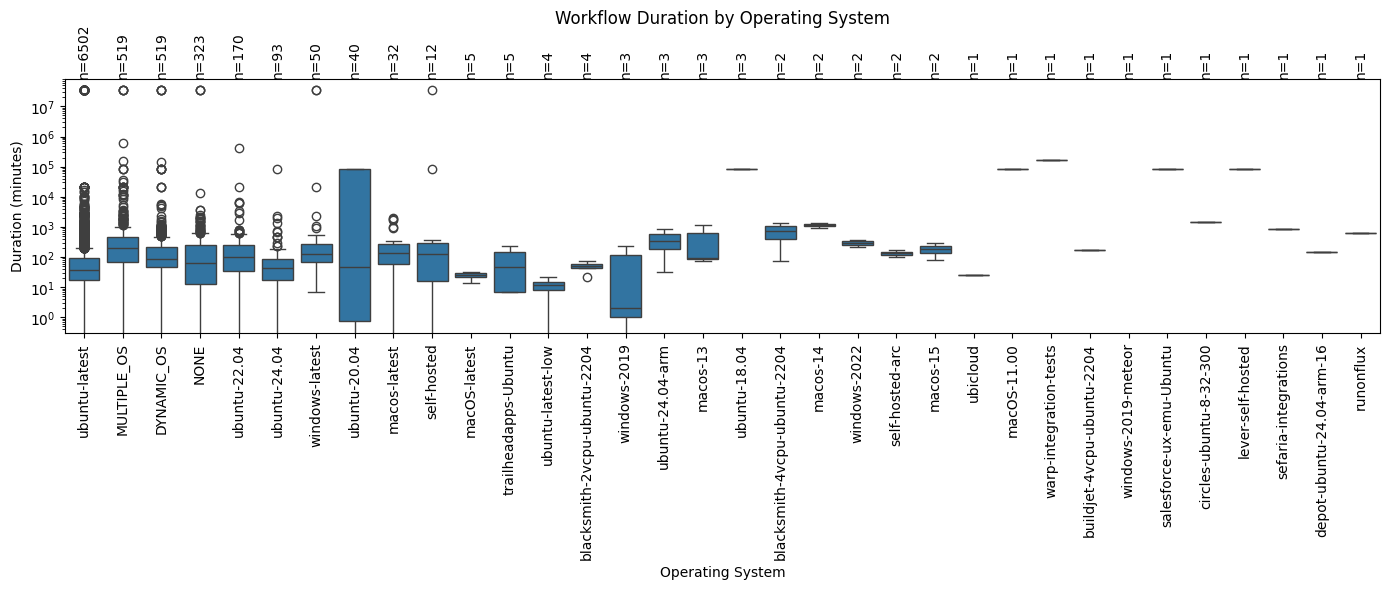

In [420]:
os_counts = df_ci_data_yml_files['operating_systems_normalized'].value_counts()

plt.figure(figsize=(14,6))
ax = sns.boxplot(
    x='operating_systems_normalized',
    y='duration_sec',
    data=df_ci_data_yml_files,
    order=os_counts.index 
)

plt.yscale('log')
plt.xlabel('Operating System')
plt.ylabel('Duration (minutes)')
plt.title('Workflow Duration by Operating System', pad=40)


for i, os_name in enumerate(os_counts.index):
    count = os_counts[os_name]
    ax.text(
        i,                      
        ax.get_ylim()[1]*1.05, 
        f"n={count}",           
        ha='center',           
        va='bottom',           
        rotation=90,            
        fontsize=10
    )

plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

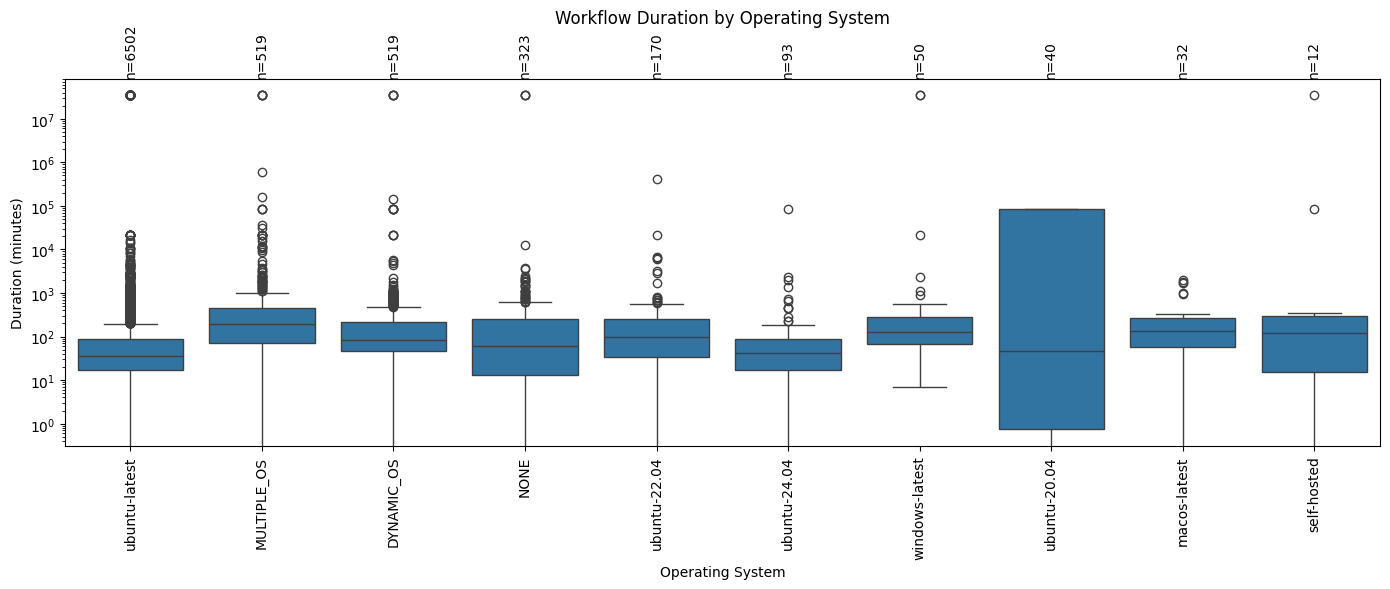

In [421]:
os_counts = df_ci_data_yml_files['operating_systems_normalized'].value_counts()

os_counts_filtered = os_counts[os_counts >= 10]

plt.figure(figsize=(14,6))
ax = sns.boxplot(
    x='operating_systems_normalized',
    y='duration_sec',
    data=df_ci_data_yml_files[df_ci_data_yml_files['operating_systems_normalized'].isin(os_counts_filtered.index)],
    order=os_counts_filtered.index 
)

plt.yscale('log')
plt.xlabel('Operating System')
plt.ylabel('Duration (minutes)')
plt.title('Workflow Duration by Operating System', pad=40)

for i, os_name in enumerate(os_counts_filtered.index):
    count = os_counts_filtered[os_name]
    ax.text(
        i,                      
        ax.get_ylim()[1]*1.05, 
        f"n={count}",           
        ha='center',           
        va='bottom',           
        rotation=90,            
        fontsize=10
    )

plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

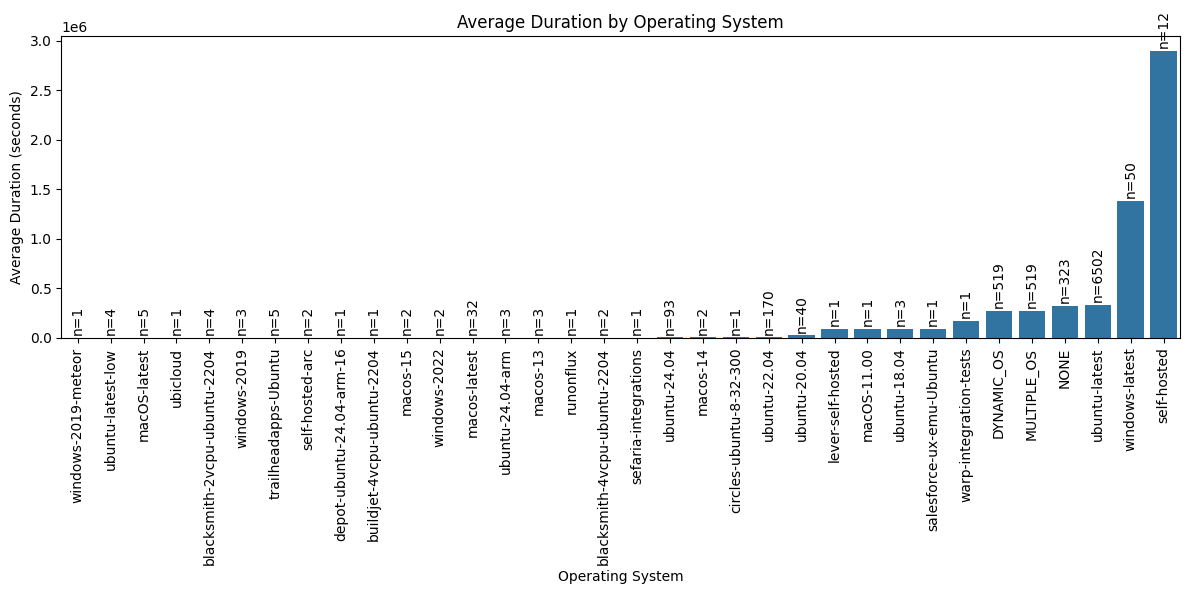

In [424]:
avg_duration = df_ci_data_yml_files.groupby('operating_systems_normalized')['duration_sec'].mean().sort_values()

os_counts = df_ci_data_yml_files['operating_systems_normalized'].value_counts()
os_counts = os_counts.reindex(avg_duration.index)  # align with avg_duration

plt.figure(figsize=(12,6))
ax = sns.barplot(x=avg_duration.index, y=avg_duration.values)

for i, os_name in enumerate(avg_duration.index):
    count = os_counts[os_name]
    ax.text(
        i, 
        avg_duration[os_name] + avg_duration.max()*0.01,  # slightly above the bar
        f"n={count}",
        ha='center',
        va='bottom',
        fontsize=10,
        rotation=90
    )

plt.xticks(rotation=90)
plt.title("Average Duration by Operating System")
plt.xlabel("Operating System")
plt.ylabel("Average Duration (seconds)")
plt.tight_layout()
plt.show()

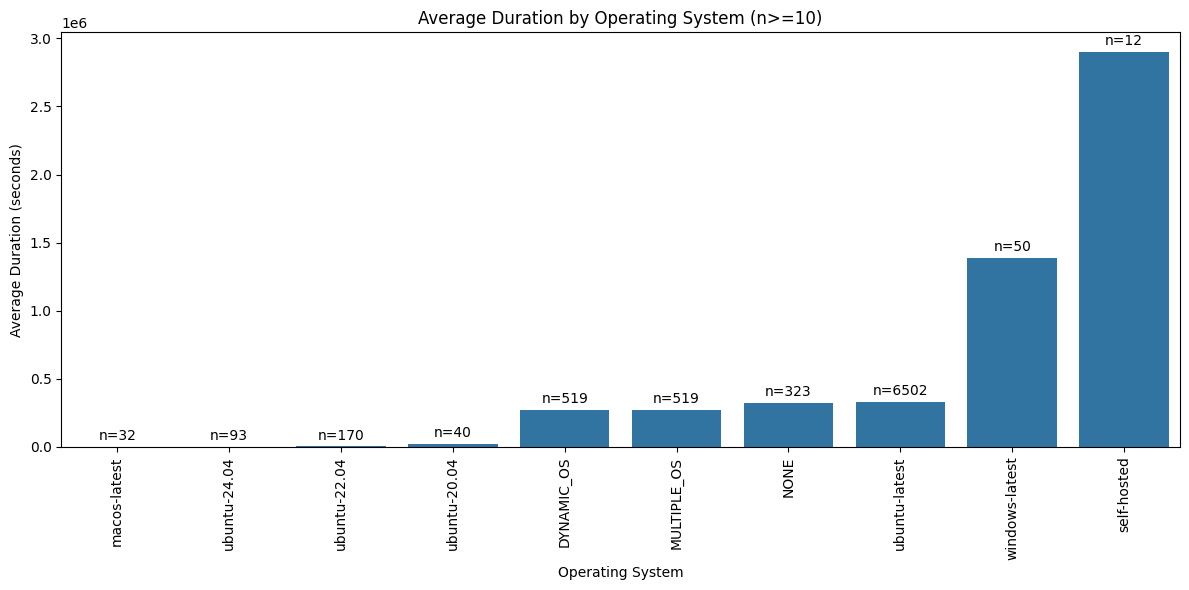

In [425]:
os_counts = df_ci_data_yml_files['operating_systems_normalized'].value_counts()

os_counts_filtered = os_counts[os_counts >= 10]

avg_duration = df_ci_data_yml_files[df_ci_data_yml_files['operating_systems_normalized'].isin(os_counts_filtered.index)] \
               .groupby('operating_systems_normalized')['duration_sec'].mean() \
               .sort_values()

os_counts_filtered = os_counts_filtered.reindex(avg_duration.index)

plt.figure(figsize=(12,6))
ax = sns.barplot(x=avg_duration.index, y=avg_duration.values)

for i, os_name in enumerate(avg_duration.index):
    count = os_counts_filtered[os_name]
    ax.text(
        i, 
        avg_duration[os_name] + avg_duration.max()*0.01, 
        f"n={count}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.xticks(rotation=90)
plt.title("Average Duration by Operating System (n>=10)")
plt.xlabel("Operating System")
plt.ylabel("Average Duration (seconds)")
plt.tight_layout()
plt.show()

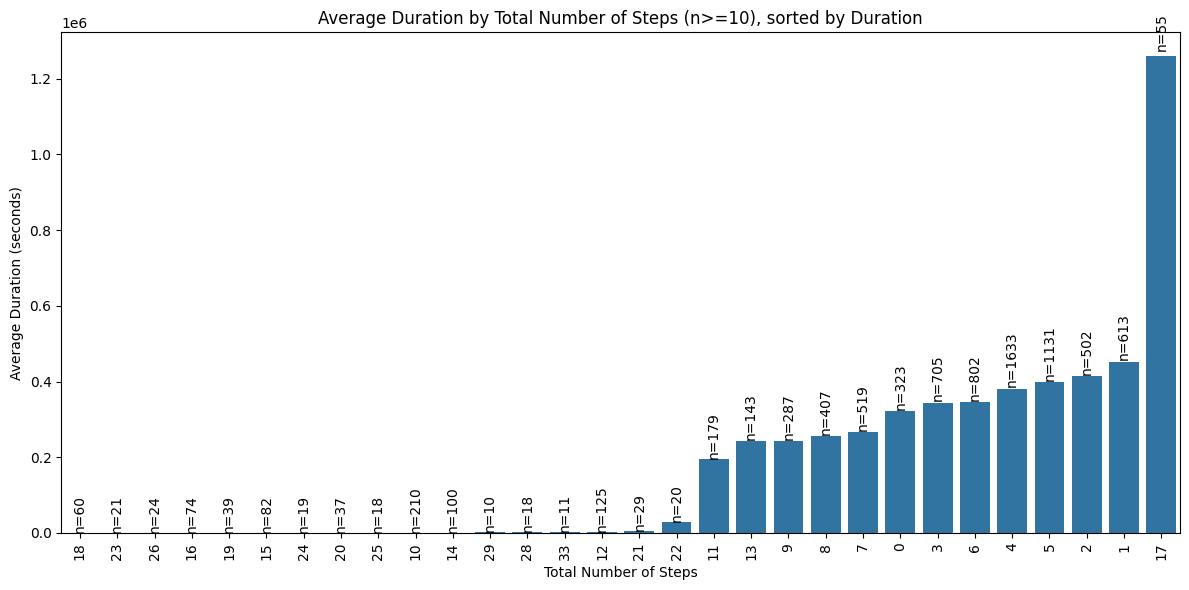

In [442]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example: avg_duration and step_counts are your precomputed Series
# Filter steps with count >= 10
step_counts_filtered = step_counts[step_counts >= 10]
avg_duration_filtered = avg_duration.loc[step_counts_filtered.index]

# Sort by average duration
avg_duration_filtered = avg_duration_filtered.sort_values(ascending=True)
step_counts_filtered = step_counts_filtered.loc[avg_duration_filtered.index]

# Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(
    x=avg_duration_filtered.index.astype(str),  # ensure x-axis labels are strings
    y=avg_duration_filtered.values
)

# Annotate bars
for i, bar in enumerate(ax.patches):
    step = avg_duration_filtered.index[i]
    count = step_counts_filtered[step]
    height = bar.get_height()
    
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height * 1.01,  # slightly above bar
        f"n={count}",
        ha='center',
        va='bottom',
        fontsize=10,
        rotation=90
    )

plt.xticks(rotation=90)
plt.title("Average Duration by Total Number of Steps (n>=10), sorted by Duration")
plt.xlabel("Total Number of Steps")
plt.ylabel("Average Duration (seconds)")
plt.tight_layout()
plt.show()